In [1]:
import re

import pystac

from dask.distributed import LocalCluster

import geopandas as gpd
from shapely import Polygon

import fsspec
import xarray as xr
import nsidc_datasets.preprocess as preprocess

collection_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json'  # CDR Stac Collection

Start a dask local cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.03 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43493,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.03 GiB
Comm: tcp://127.0.0.1:34237,Total threads: 4
Dashboard: http://127.0.0.1:38661/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:41757,


## Open and explore a STAC Collection

A STAC collection contains items. 

In [3]:
collection = pystac.Collection.from_file(collection_url)

In [4]:
print(collection.id)
print(collection.title)
print(collection.description)

noaa-cdr-sea-ice-concentration
Sea Ice Concentration CDR
The Sea Ice Concentration Climate Data Record (CDR) provides a consistent daily and monthly time series of sea ice concentrations for both the north and south Polar Regions on a 25 km x 25 km grid. These data can be used to estimate how much of the ocean surface is covered by ice, and monitor changes in sea ice concentration. The CDR combines concentration estimates using two algorithms developed at the NASA Goddard Space Flight Center (GSFC). Gridded brightness temperatures acquired from a number of Defense Meteorological Satellite Program (DMSP) passive microwave radiometers provide the necessary input to produce the dataset.


In [5]:
items = list(collection.get_all_items())
print(f"{collection.id} has {len(items)} items")

noaa-cdr-sea-ice-concentration has 94 items


In [6]:
# Only show first 10 items
# Change items[:10] to see more or less items
for item in items[:10]:
    print(f"  {item.id}")

  seaice_conc_daily_nh_2024_v04r00
  seaice_conc_daily_sh_2024_v04r00
  seaice_conc_monthly_nh_197811_202406_v04r00
  seaice_conc_monthly_sh_197811_202406_v04r00
  seaice_conc_daily_sh_2023_v04r00
  seaice_conc_daily_sh_2022_v04r00
  seaice_conc_daily_sh_2021_v04r00
  seaice_conc_daily_sh_2020_v04r00
  seaice_conc_daily_sh_2019_v04r00
  seaice_conc_daily_sh_2018_v04r00


A STAC collection is not searchable by itself unless it is hosted on a STAC endpoint.  However, we can create a searchable pseudo-geospatial database using Geopandas.  We can then search for STAC items using the GeoDataFrame geometry and also using other columns.

Here, we create a `geopandas.GeoDataFrame` using the `start_datetime` and `end_datetime`, and spatial extent for each item.  We also add `timestep` and `hemisphere` as additional metadata to allow searching for daily or monthly data, and a simple hemisphere search.

:::{note}
Because all items in the Sea Ice CDR collection cover either the northern or southern hemisphere, geometry is not really necessary.  A simple hemisphere indicator would suffice.
:::

We will extract timestep and hemisphere from the `item.id` for each item using a regular expression search.

:::{note}  
See [Regular Expression HowTo](https://docs.python.org/3/howto/regex.html) for more information.  
:::

The `groups` returned by `p.search` are the strings in the parentheses `()`.  These strings are returned as a tuple.  The list-comprehension returns a list of tuples.  The expression `zip(*list)` is used to "split" the contents of the tuples into two lsts; one for `timestep` and one for `hemipshere`

In [7]:
p = re.compile(r"seaice_conc_(\w*)_([ns])h_\d{4}")

timestep, hemisphere = zip(*[p.search(item.id).groups() for item in items])

We then create a `geopandas.GeoDataFrame` containing `start_time`, `end_time`, `timestep`, `hemisphere`, and `url`.  The GeoDataFrame is indexed by `item.id`.  The geometry is created from the `item.geometry` object for each item that is cast as a `shapely.Polygon` object.  We use _list comprehensions_ to extract this information for each item.  Finally, the WGS84 CRS (EPSG:4236) is assigned to the GeoDataFrame.  This allows us to do coordinate transformations and geospatial queries using polygons and points in a different coordinate system.

In [8]:
gdf = gpd.GeoDataFrame({
    "start_datetime": [item.common_metadata.start_datetime for item in items],
    "end_datetime": [item.common_metadata.end_datetime for item in items],
    "url": [item.assets["netcdf"].href for item in items],
    "timestep": timestep,
    "hemisphere": hemisphere,
}, 
                       index = [item.id for item in items],
                       geometry = [Polygon(item.geometry["coordinates"][0]) for item in items],
                       crs = 4326,
                      )
gdf.head()                   

,start_datetime,end_datetime,url,timestep,hemisphere,geometry
seaice_conc_daily_nh_2024_v04r00,2024-01-01 00:00:00+00:00,2024-06-30 23:59:59+00:00,https://noaadata.apps.nsidc.org/NOAA/G02202_V4...,daily,n,"POLYGON ((180 31.35, 180 90, -180 90, -180 31...."
seaice_conc_daily_sh_2024_v04r00,2024-01-01 00:00:00+00:00,2024-06-30 23:59:59+00:00,https://noaadata.apps.nsidc.org/NOAA/G02202_V4...,daily,s,"POLYGON ((180 -90, 180 -41.45, -180 -41.45, -1..."
seaice_conc_monthly_nh_197811_202406_v04r00,1978-11-01 00:00:00+00:00,2024-06-30 23:59:59+00:00,https://noaadata.apps.nsidc.org/NOAA/G02202_V4...,monthly,n,"POLYGON ((180 31.35, 180 90, -180 90, -180 31...."
seaice_conc_monthly_sh_197811_202406_v04r00,1978-11-01 00:00:00+00:00,2024-06-30 23:59:59+00:00,https://noaadata.apps.nsidc.org/NOAA/G02202_V4...,monthly,s,"POLYGON ((180 -90, 180 -41.45, -180 -41.45, -1..."
seaice_conc_daily_sh_2023_v04r00,2023-01-01 00:00:00+00:00,2023-12-31 23:59:59+00:00,https://noaadata.apps.nsidc.org/NOAA/G02202_V4...,daily,s,"POLYGON ((180 -90, 180 -41.45, -180 -41.45, -1..."


In [9]:
urls = sorted(gdf[(gdf.timestep == "daily") & (gdf.hemisphere == "n")]["url"].to_list())
print(f"Found {len(urls)} assets")
print(urls[:10])

Found 47 assets
['https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1978_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1979_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1980_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1981_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1982_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1983_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1984_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1985_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_daily_nh_1986_v04r00.nc', 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/s

In [11]:
%%time
fs = fsspec.filesystem("https")
files = [fs.open(url) for url in urls]

ds = xr.open_mfdataset(files, decode_coords="all", chunks={}, 
                       parallel=True, preprocess=preprocess.nsidc_seaice_cdr, 
                       data_vars="minimal", coords="minimal",
                       compat="override", engine="h5netcdf")
ds

CPU times: user 8.45 s, sys: 1.37 s, total: 9.81 s
Wall time: 1min 49s


<xarray.Dataset> Size: 27GB
Dimensions:     (time: 16686, y: 448, x: 304)
Coordinates:
    projection  |S1 1B ...
  * time        (time) datetime64[ns] 133kB 1978-10-25 1978-10-26 ... 2024-06-30
  * x           (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
Data variables:
    mask        (time, y, x) int64 18GB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    sic         (time, y, x) float32 9GB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T17:09:43Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

This takes a while because the full processing graph needs to be computed.  The warning suggests a work around.

/home/apbarret/mambaforge/envs/seaice-cdr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


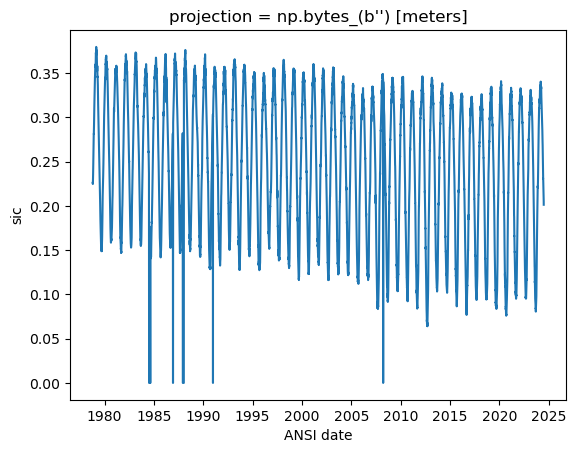

In [13]:
%%time
ds.sic.mean(dim=["x","y"]).plot()

In [14]:
%%time
ds.to_zarr("seaice_conc_daily_nh_v04r00.zarr", mode="w")  # mode="w" allows overwriting

/home/apbarret/mambaforge/envs/seaice-cdr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [15]:
ds.close()

In [16]:
ds = xr.open_zarr("seaice_conc_daily_nh_v04r00.zarr")

/home/apbarret/mambaforge/envs/seaice-cdr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 25.1 s, sys: 1.19 s, total: 26.3 s
Wall time: 28.3 s


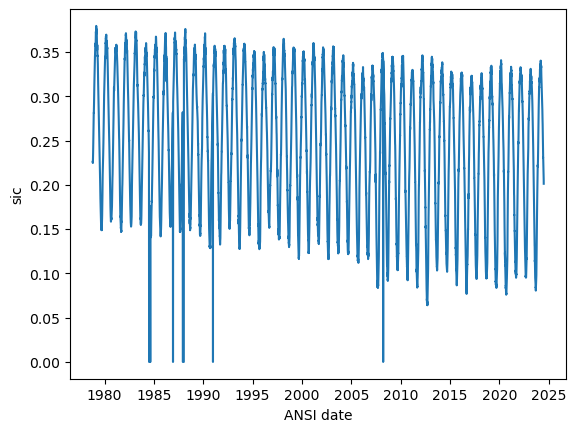

In [17]:
%%time
ds.sic.mean(dim=["x","y"]).plot()